In [13]:
from __future__ import absolute_import, division, print_function

In [14]:
%matplotlib inline 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [15]:
#linear regression, with additive noise
f = lambda x, e: 2*x + 3 + e
f_vec =  np.vectorize(f)

In [16]:
samples = 200
e_data = np.random.normal(0.0, 0.2, samples)
x_data = np.random.rand(samples)
y_data = f_vec(x_data,e_data)

# transform into columns
x_data = x_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)

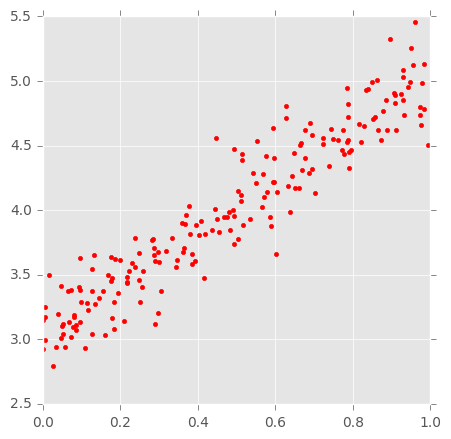

In [17]:
plt.figure(figsize=(5,5))
plt.plot(x_data, y_data, 'r.')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

In [19]:
import tensorflow as tf

In [20]:
# Set parameters
learning_rate = 0.01
training_iteration = 5
batch_size = 5

FLAGS = None

In [21]:
# TF graph input
x = tf.placeholder('float', [None, 1]) 
y = tf.placeholder('float', [None, 1]) 

In [22]:
# Set model weights
w = tf.Variable(tf.zeros([1]), name='w')
b = tf.Variable(tf.zeros([1]), name='b')

In [23]:
with tf.name_scope("wx_b") as scope:
    # Construct a linear model
    y_hat = w*x + b
    
    # Add summary ops to collect data
    tf.histogram_summary("weights", w)
    tf.histogram_summary("biases", b)

In [24]:
# More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    # Minimize sum squared errors
    cost_function = tf.reduce_sum(tf.pow(y_hat-y,2))
    # Create a summary to monitor the cost function
    tf.scalar_summary("cost_function", cost_function)

In [25]:
with tf.name_scope("train") as scope:
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [26]:
# Initializing the variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.merge_all_summaries()

In [27]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

In [30]:
# Change this to a location on your computer
summary_writer = tf.train.SummaryWriter('./tensorboard', graph=sess.graph)

In [31]:
# Training cycle
for iteration in range(training_iteration):
    avg_cost = 0.
    total_batch = int(samples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_range = slice(batch_size*i,batch_size*(i+1))
        batch_xs = np.copy(x_train[batch_range])
        batch_ys = np.copy(y_train[batch_range])
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x : batch_xs, y: batch_ys})
        
        #cost
        cost = sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})
        
        # Compute the average loss
        avg_cost += cost/total_batch

        # Write logs for each iteration
        summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys})
        summary_writer.add_summary(summary_str, iteration*total_batch + i)
        
    # Display logs per iteration step
    print("Iteration: {:04d} cost= {:.9f}".format((iteration+1),avg_cost))


Iteration: 0001 cost= 6.712727367
Iteration: 0002 cost= 0.182156378
Iteration: 0003 cost= 0.177368295
Iteration: 0004 cost= 0.174083150
Iteration: 0005 cost= 0.171987520


In [32]:
# Calculate accuracy
mse = tf.reduce_mean(tf.pow(y_hat-y,2))
print("Test accuracy (MSE):", mse.eval({x: x_test, y: y_test}))


Test accuracy (MSE): 0.0320387


In [33]:
w_ = w.eval()[0]
b_ = b.eval()[0]
print("Regression a = {:.2}, b = {:.2}".format(w_, b_))

Regression a = 1.9, b = 3.1


In [34]:
y_test_predict = sess.run(y_hat, feed_dict={x:x_test})
y_test_predict[:10]

array([[ 3.15962911],
       [ 3.47001457],
       [ 3.08811331],
       [ 4.37028694],
       [ 4.33101654],
       [ 4.87552929],
       [ 3.57781744],
       [ 3.24255037],
       [ 4.76691008],
       [ 4.07869291]], dtype=float32)

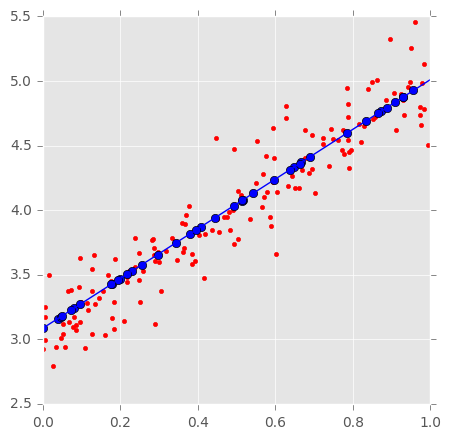

In [35]:
plt.figure(figsize=(5,5))
plt.plot(x_train, y_train, 'r.')
plt.plot(x_test, y_test_predict, 'bo')
plt.plot([b_,w_*1+b_], 'b-')
plt.show()


In [ ]:
# Close the Session when we're done.
sess.close()